In [1]:
import shap
import lime
import lime.lime_tabular

import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, make_scorer, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV


import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import linear_model

from sklearn.svm import SVC

from aix360.algorithms.protodash import ProtodashExplainer

import warnings
warnings.simplefilter(action ='ignore')

c:\Users\User\OneDrive\Documents\RMIT\y2sem2\Case Studies in Data Science\assignments\LoanPredictions_Repo\flask_app\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


change the directory according to your dirve

In [2]:
heloc = pd.read_csv("../data/heloc_dataset.csv")
#heloc.head()


# **1. EDA**

### **Label Encoding**

"Bad":1  
"Good":0

In [3]:
df= heloc.copy()
df.replace({"Bad":1, "Good":0}, inplace=True)
df.head()

RiskPerformance  ExternalRiskEstimate  MSinceOldestTradeOpen  \
0                1                    55                    144   
1                1                    61                     58   
2                1                    67                     66   
3                1                    66                    169   
4                1                    81                    333   

   MSinceMostRecentTradeOpen  AverageMInFile  NumSatisfactoryTrades  \
0                          4              84                     20   
1                         15              41                      2   
2                          5              24                      9   
3                          1              73                     28   
4                         27             132                     12   

   NumTrades60Ever2DerogPubRec  NumTrades90Ever2DerogPubRec  \
0                            3                            0   
1                            4                            4   
2                            0                            0   
3                            1                            1   
4                            0                            0   

   PercentTradesNeverDelq  MSinceMostRecentDelq  ...  PercentInstallTrades  \
0                      83                     2  ...                    43   
1                     100                    -7  ...                    67   
2                     100                    -7  ...                    44   
3                      93                    76  ...                    57   
4                     100                    -7  ...                    25   

   MSinceMostRecentInqexcl7days  NumInqLast6M  NumInqLast6Mexcl7days  \
0                             0             0                      0   
1                             0             0                      0   
2                             0             4                      4   
3                             0             5                      4   
4                             0             1                      1   

   NetFractionRevolvingBurden  NetFractionInstallBurden  \
0                          33                        -8   
1                           0                        -8   
2                          53                        66   
3                          72                        83   
4                          51                        89   

   NumRevolvingTradesWBalance  NumInstallTradesWBalance  \
0                           8                         1   
1                           0                        -8   
2                           4                         2   
3                           6                         4   
4                           3                         1   

   NumBank2NatlTradesWHighUtilization  PercentTradesWBalance  
0                                   1                     69  
1                                  -8                      0  
2                                   1                     86  
3                                   3                     91  
4                                   0                     80  

[5 rows x 24 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10459 entries, 0 to 10458
Data columns (total 24 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   RiskPerformance                     10459 non-null  int64
 1   ExternalRiskEstimate                10459 non-null  int64
 2   MSinceOldestTradeOpen               10459 non-null  int64
 3   MSinceMostRecentTradeOpen           10459 non-null  int64
 4   AverageMInFile                      10459 non-null  int64
 5   NumSatisfactoryTrades               10459 non-null  int64
 6   NumTrades60Ever2DerogPubRec         10459 non-null  int64
 7   NumTrades90Ever2DerogPubRec         10459 non-null  int64
 8   PercentTradesNeverDelq              10459 non-null  int64
 9   MSinceMostRecentDelq                10459 non-null  int64
 10  MaxDelq2PublicRecLast12M            10459 non-null  int64
 11  MaxDelqEver                         10459 non-null  int64
 12  NumT

In [5]:
# STUFF I ADDED - Oliver

features = df[df.columns[1:]]
features.describe().drop(["count", "std", "25%", "50%", "75%"]).T.reset_index(level=0).rename({'index':'feature'}, axis=1).to_csv("../data/feature_details.csv")

**Separating predictor features**

In [6]:
# take the label away
predictor = heloc.iloc[:, 1:].copy()
#predictor.info()

In [7]:
print("SPECIAL VALUES: ")
for i in range(23):
    print(i+1, ".", predictor.iloc[:, i].name, end=': ')
    for x in predictor.iloc[:, i].unique():
        if x < 0:
            print(x, end=', ')
    print()

SPECIAL VALUES: 
1 . ExternalRiskEstimate: -9, 
2 . MSinceOldestTradeOpen: -9, -8, 
3 . MSinceMostRecentTradeOpen: -9, 
4 . AverageMInFile: -9, 
5 . NumSatisfactoryTrades: -9, 
6 . NumTrades60Ever2DerogPubRec: -9, 
7 . NumTrades90Ever2DerogPubRec: -9, 
8 . PercentTradesNeverDelq: -9, 
9 . MSinceMostRecentDelq: -7, -8, -9, 
10 . MaxDelq2PublicRecLast12M: -9, 
11 . MaxDelqEver: -9, 
12 . NumTotalTrades: -9, 
13 . NumTradesOpeninLast12M: -9, 
14 . PercentInstallTrades: -9, 
15 . MSinceMostRecentInqexcl7days: -9, -7, -8, 
16 . NumInqLast6M: -9, 
17 . NumInqLast6Mexcl7days: -9, 
18 . NetFractionRevolvingBurden: -8, -9, 
19 . NetFractionInstallBurden: -8, -9, 
20 . NumRevolvingTradesWBalance: -8, -9, 
21 . NumInstallTradesWBalance: -8, -9, 
22 . NumBank2NatlTradesWHighUtilization: -8, -9, 
23 . PercentTradesWBalance: -9, -8, 


-> All predictor columns have special values

In [8]:
for i in range(23):
  print(predictor.iloc[:, i].name, end=': ')
  print(predictor.iloc[:, i].unique())
  print()

ExternalRiskEstimate: [55 61 67 66 81 59 54 68 82 50 74 69 63 62 89 65 57 72 64 58 79 71 75 88
 51 70 78 86 90 76 73 83 87 -9 91 84 60 77 56 92 49 80 85 93 52 45 94 47
 43 48 40 39 44 36 37 53 34 46 33 42 41]

MSinceOldestTradeOpen: [144  58  66 169 333 137  88 148 324  79  96 311 274 256 262 184 131 244
  43 147 365  84  91 265 150 162 284 476 179 114 133 164 118 153 186 127
 116  21 318 230 293  37 255 209 398 326 478 197 243 183 176 368  -9 300
 168 277 174 126 409 419 282 134 155  70 294 357 106  85 204 151 307  17
 188 107 378 299  76 211 220 177 112 224 152 120 246 123 212 208 203 160
 103 159 241  61 178 198 258  41  14 233 252  -8 154  97 136 190 221 242
 132 245  27 139 222 218 156  82 247 129  93 321 338 195 145 352 205 135
 433 175 344 140 502 334 182 267 340 439 295 286 111 399  90  99 415 288
 163 281 407 191 180  69 363 253 170 325 474 234 432 130 251 280 125 408
 271 306 232 336 264 254 165 273 161 250 173  81 290 279 196  77  94  74
 219 369 266 375 291 122  72 269 343 

Value	Meaning

-9	: No Bureau Record or No Investigation

-8 :	No Usable/Valid Trades or Inquiries

-7: 	Condition not Met (e.g. No Inquiries, No Delinquencies)




In [9]:
# get the index of special values
indices = []
for i in range(df.shape[0]):
  conditon = predictor.iloc[i, :] <0
  if conditon.any():
    indices.append(i)
# there 7957 rows have missing values which is a lot -> should not delete them
len(indices)

7957

**Due with Special Values**

In [10]:
# replace special valuess to nan
df.replace({-7:np.NaN, -8:np.NaN, -9:np.NaN}, inplace=True)

In [11]:
# replace nan to mean
for i in range(1,24,1):
  df.iloc[:, i] = df.iloc[:, i].fillna(df.iloc[:, i].mean().round())


IMPORTANCE FEATURES:
1. ExternalRiskEstimate
2.  NumTrades60Ever2DerogPubRec
3. PercentInstallTrades
4. NetFractionInstallBurden
5. NumRevolvingTradesWBalance
6. NumInstallTradesWBalance
7. PercentTradesWBalance

In [12]:
correlation_coefficient = df.iloc[:, 1:].corr().round(1)
#correlation_coefficient

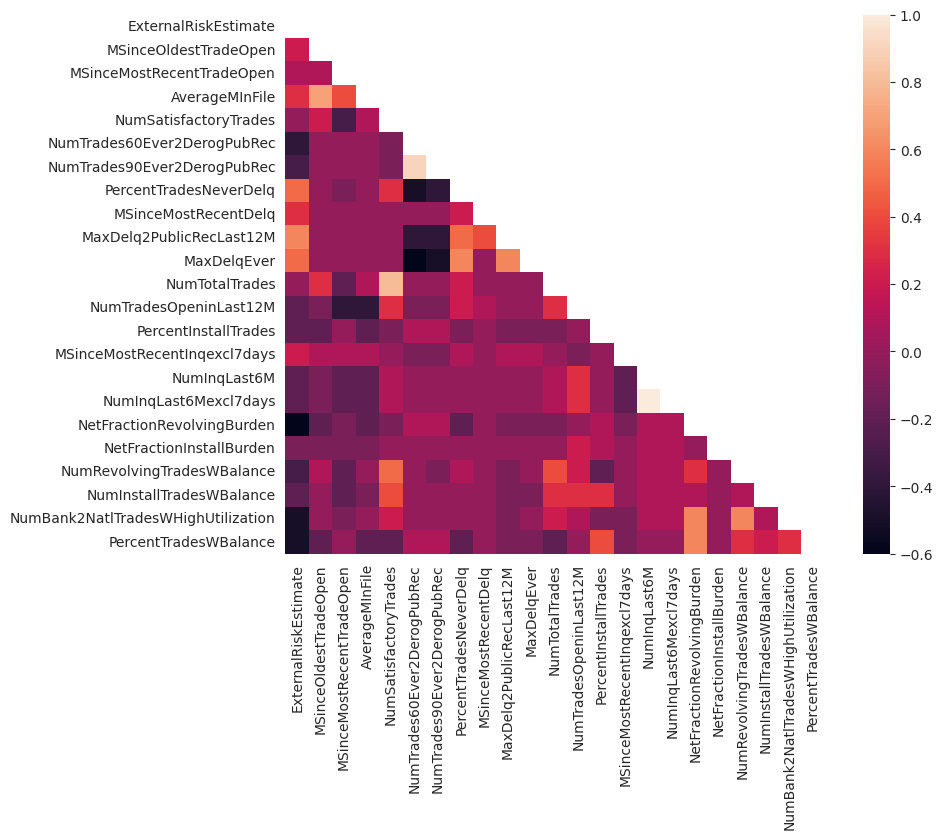

In [13]:
mask = np.zeros_like(correlation_coefficient)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10, 7))
    ax = sns.heatmap(correlation_coefficient, mask=mask, vmax=1, square=True)


### **1. 1 Spliting Data**

I splited data into 3 subsets (Train, Test and Dummy)

Dummy set is used for Front end (Pay Attention **Oliver**)

Divide data into 3 subsets  
Train  
Test  
Dummy (for frontend experiment)

In [14]:
X = df.drop('RiskPerformance', axis=1)
y = df['RiskPerformance']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=8)
X_test, X_dummy, y_test, y_dummy = train_test_split(X_test, y_test, test_size=0.002, random_state=8)


In [15]:
# data for Frontend
X_dummy

ExternalRiskEstimate  MSinceOldestTradeOpen  MSinceMostRecentTradeOpen  \
9                     61.0                   79.0                        4.0   
4359                  82.0                  125.0                       16.0   
8166                  84.0                  403.0                       14.0   
9611                  85.0                  208.0                        2.0   
1492                  63.0                  140.0                       13.0   
7957                  73.0                  422.0                        2.0   
8384                  72.0                  252.0                        1.0   

      AverageMInFile  NumSatisfactoryTrades  NumTrades60Ever2DerogPubRec  \
9               36.0                   19.0                          0.0   
4359            63.0                    9.0                          0.0   
8166           157.0                   26.0                          0.0   
9611            73.0                   11.0                          0.0   
1492            76.0                   22.0                          0.0   
7957            62.0                   42.0                          0.0   
8384            80.0                   48.0                          0.0   

      NumTrades90Ever2DerogPubRec  PercentTradesNeverDelq  \
9                             0.0                    95.0   
4359                          0.0                   100.0   
8166                          0.0                   100.0   
9611                          0.0                   100.0   
1492                          0.0                    95.0   
7957                          0.0                    98.0   
8384                          0.0                   100.0   

      MSinceMostRecentDelq  MaxDelq2PublicRecLast12M  ...  \
9                      5.0                       4.0  ...   
4359                  22.0                       7.0  ...   
8166                  22.0                       7.0  ...   
9611                  22.0                       7.0  ...   
1492                  22.0                       6.0  ...   
7957                  11.0                       4.0  ...   
8384                  22.0                       7.0  ...   

      PercentInstallTrades  MSinceMostRecentInqexcl7days  NumInqLast6M  \
9                     26.0                           0.0           6.0   
4359                  33.0                           0.0           1.0   
8166                   7.0                          13.0           0.0   
9611                  38.0                           1.0           2.0   
1492                  23.0                           0.0           3.0   
7957                  23.0                           0.0           4.0   
8384                  20.0                           0.0           3.0   

      NumInqLast6Mexcl7days  NetFractionRevolvingBurden  \
9                       6.0                        31.0   
4359                    0.0                        28.0   
8166                    0.0                         3.0   
9611                    2.0                        19.0   
1492                    3.0                        91.0   
7957                    4.0                        12.0   
8384                    3.0                        17.0   

      NetFractionInstallBurden  NumRevolvingTradesWBalance  \
9                         86.0                         5.0   
4359                      69.0                         1.0   
8166                      69.0                        11.0   
9611                      69.0                         2.0   
1492                      69.0                         2.0   
7957                      69.0                         4.0   
8384                      88.0                         5.0   

      NumInstallTradesWBalance  NumBank2NatlTradesWHighUtilization  \
9                          3.0                                 1.0   
4359                       1.0                                 0.0   
8166 

# **2. Train model**

***3 models: XGBoost, Decision Tree and Support Vector Machine***

## **Neural Network**   (Dont use this)
Give 70% accuracy but Can't get the shap to work on this model

In [16]:
#X = df.drop('RiskPerformance', axis=1).to_numpy()
#Y = df['RiskPerformance'].to_numpy()

#X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.33, random_state=42)

#neural_net = make_pipeline(
    #StandardScaler(),
    #MLPClassifier(hidden_layer_sizes=(3,),activation='relu',solver='adam',  max_iter=10000,learning_rate='constant',random_state=0, early_stopping=True)   
#)

#neural_net.fit(X_train, y_train)

#neural_net.predict_proba(X_test[0:])

#neural_net.score(X_test, y_test)

#explainer = shap.KernelExplainer(neural_net.predict,X_train)

#shap_values = explainer.shap_values(X_test,nsamples=100)

#shap.summary_plot(shap_values,X_test,feature_names=features)

## **2.1 XGBOOST**

**Build model**

[23:02:21] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "col_sample_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




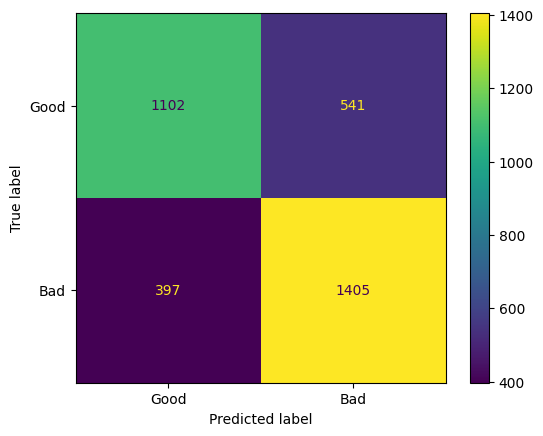

In [17]:
xgb_model = xgb.XGBClassifier(objective="reg:logistic", 
                              seed=70, 
                              col_sample_bytree=0.4,
                              learning_rate= 0.01, 
                              max_depth= 5,
                              n_estimators=500,
                              alpha=10)

xgb_model.fit(X_train.values, y_train)
plot_confusion_matrix(xgb_model,X_test.values,  y_test, values_format='d', display_labels =["Good", "Bad"]  )

In [18]:
xgb_pred = xgb_model.predict(X_test.values)
print('Training accuracy:', accuracy_score(y_train, xgb_model.predict(X_train.values)))
print('Test accuracy:', accuracy_score(y_test, xgb_pred))
print('ROC_AUC: ', roc_auc_score(y_test, xgb_pred))
print(classification_report(y_test, xgb_pred, target_names=["Approved", "Denied"]))

Training accuracy: 0.7502497502497503
Test accuracy: 0.7277213352685051
ROC_AUC:  0.725206759514518
              precision    recall  f1-score   support

    Approved       0.74      0.67      0.70      1643
      Denied       0.72      0.78      0.75      1802

    accuracy                           0.73      3445
   macro avg       0.73      0.73      0.73      3445
weighted avg       0.73      0.73      0.73      3445



In [19]:
# feature importance
#plot_importance(xgb_model, )


Create a test dataframe which consists of actual label and predicted label

In [20]:
test = y_test.to_frame()
test['predict'] = xgb_pred
test.rename(columns={"RiskPerformance":"actual"}, inplace=True)
test.sample(5)

actual  predict
165      1.0        0
7167     1.0        1
8119     0.0        0
442      1.0        1
5602     1.0        0

In [21]:
'''
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=predictor.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')
'''

"\nexplainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, \n                                                   feature_names=predictor.columns, \n                                                   verbose=True, \n                                                   class_names=['Approved', 'Denied'],\n                                                   mode='classification')\n"

Separating approved and denied observations from test set

In [22]:
denied = test[test['predict']== 1].index
approved = test[test['predict']== 0].index


***Visualizing Bad observations*** based on prediction




Observation 1:

In [23]:
'''
denied_index =np.random.choice(denied )
print(y_test.loc[denied_index])
X_test.loc[denied_index]
'''

'\ndenied_index =np.random.choice(denied )\nprint(y_test.loc[denied_index])\nX_test.loc[denied_index]\n'

In [24]:
'''
print('Predict:',test.loc[denied_index, "predict"])
#xgb_model.predict(X_test.loc[bad_index])[0]
print("Actual:" , test.loc[denied_index, 'actual'])

exp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\nprint(\'Predict:\',test.loc[denied_index, "predict"])\n#xgb_model.predict(X_test.loc[bad_index])[0]\nprint("Actual:" , test.loc[denied_index, \'actual\'])\n\nexp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 2:
Wrong Prediction

In [25]:
'''
wrong_predit = []
for i in test.index:
  if test.loc[i, 'predict'] == 1 :
    if test.loc[i, 'actual'] == 0:
      wrong_predit.append(i)
'''

"\nwrong_predit = []\nfor i in test.index:\n  if test.loc[i, 'predict'] == 1 :\n    if test.loc[i, 'actual'] == 0:\n      wrong_predit.append(i)\n"

In [26]:
'''
bad_index =np.random.choice(wrong_predit)
print('Predict:',test.loc[denied_index, "predict"])
print("Actual:" , test.loc[denied_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[denied_index ],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\nbad_index =np.random.choice(wrong_predit)\nprint(\'Predict:\',test.loc[denied_index, "predict"])\nprint("Actual:" , test.loc[denied_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[denied_index ],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 3:

In [27]:
'''
bad_index =np.random.choice(denied)
print('Predict:',test.loc[denied_index, "predict"])
print("Actual:" , test.loc[denied_index, 'actual'])

exp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\nbad_index =np.random.choice(denied)\nprint(\'Predict:\',test.loc[denied_index, "predict"])\nprint("Actual:" , test.loc[denied_index, \'actual\'])\n\nexp = explainer.explain_instance(X_test.loc[denied_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

***Visualising Good Observations***

Observation 1:

In [28]:
'''
approved_index =np.random.choice(approved)
print(y_test.loc[approved_index])
X_test.loc[approved_index]
'''

'\napproved_index =np.random.choice(approved)\nprint(y_test.loc[approved_index])\nX_test.loc[approved_index]\n'

In [29]:
'''
approved_index =np.random.choice(approved)
print('Predict:',test.loc[approved_index, "predict"])
print("Actual:" , test.loc[approved_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\napproved_index =np.random.choice(approved)\nprint(\'Predict:\',test.loc[approved_index, "predict"])\nprint("Actual:" , test.loc[approved_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 2:

In [30]:
'''
approved_index =np.random.choice(approved)
print('Predict:',test.loc[approved_index, "predict"])
print("Actual:" , test.loc[approved_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\napproved_index =np.random.choice(approved)\nprint(\'Predict:\',test.loc[approved_index, "predict"])\nprint("Actual:" , test.loc[approved_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

Observation 3: Wrong Prediction

In [31]:
wrong_predit = []
for i in test.index:
  if test.loc[i, 'predict'] == 0 :
    if test.loc[i, 'actual'] == 1:
      wrong_predit.append(i)
'''
approved_index =np.random.choice(wrong_predit)
print('Predict:',test.loc[approved_index, "predict"])
print("Actual:" , test.loc[approved_index, 'actual'])
exp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)
exp.show_in_notebook(show_table=True)
'''

'\napproved_index =np.random.choice(wrong_predit)\nprint(\'Predict:\',test.loc[approved_index, "predict"])\nprint("Actual:" , test.loc[approved_index, \'actual\'])\nexp = explainer.explain_instance(X_test.loc[approved_index],  xgb_model.predict_proba, num_features=23)\nexp.show_in_notebook(show_table=True)\n'

# **2.2 Decision Tree**

In [32]:
# fit model
new_list = []

for k in range(10,23):
    dt_model = DecisionTreeClassifier(max_leaf_nodes = k, random_state=0, criterion='entropy')
    fit=dt_model.fit(X_train, y_train)
    dt_pred = dt_model.predict(X_test)
    new_list.append(accuracy_score(y_test,dt_pred))

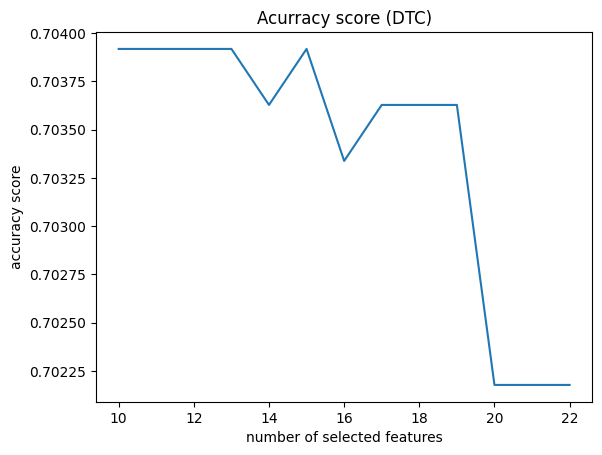

In [33]:
plt.plot(list(range(10,23)), new_list)
plt.title("Acurracy score (DTC)")
plt.xlabel('number of selected features')
plt.ylabel('accuracy score')
plt.show()

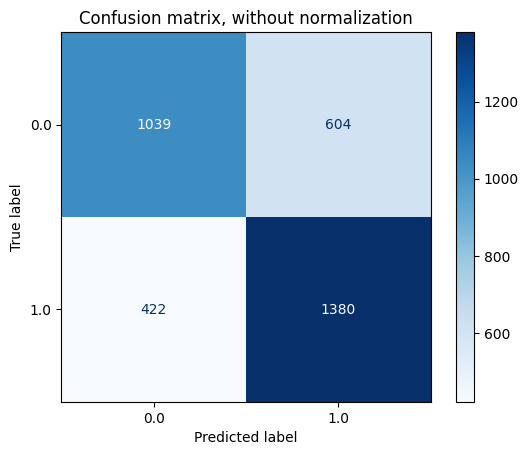

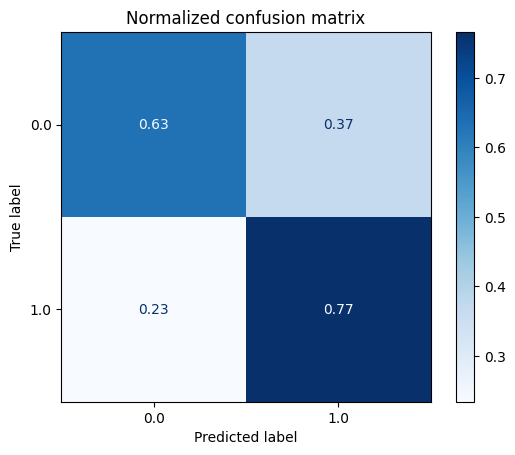

In [34]:
# confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(dt_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [35]:
# classification report
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.63      0.67      1643
         1.0       0.70      0.77      0.73      1802

    accuracy                           0.70      3445
   macro avg       0.70      0.70      0.70      3445
weighted avg       0.70      0.70      0.70      3445



# 2.3 Support Vector Machine

In [36]:
# fit model
svc = SVC(kernel='rbf', probability=True)
svc_model= svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print("Accuracy score:", accuracy_score(y_test, svc_pred))

Accuracy score: 0.7239477503628448


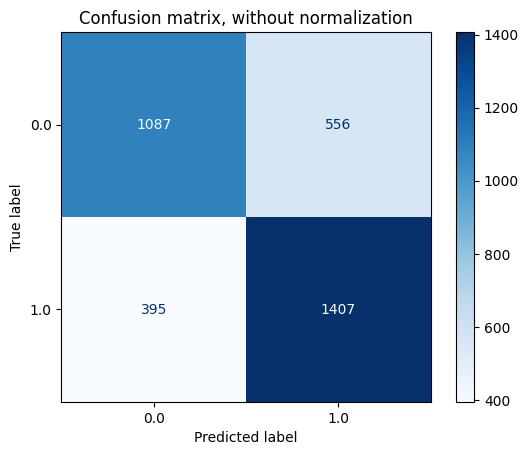

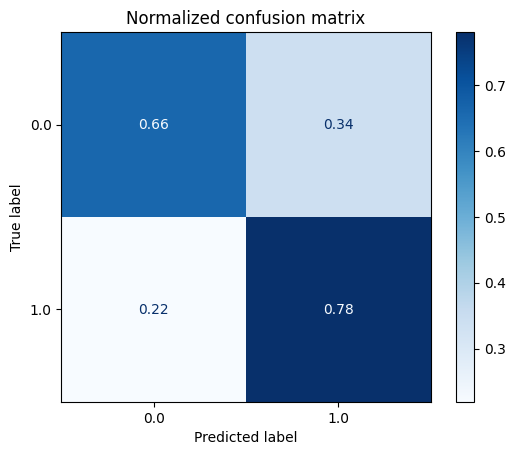

In [37]:
# confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(svc_model, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
plt.show()

In [38]:
# classification report
print(classification_report(y_test,svc_pred))

              precision    recall  f1-score   support

         0.0       0.73      0.66      0.70      1643
         1.0       0.72      0.78      0.75      1802

    accuracy                           0.72      3445
   macro avg       0.73      0.72      0.72      3445
weighted avg       0.72      0.72      0.72      3445



# **3. Global & Instances Explaination**

https://coderzcolumn.com/tutorials/machine-learning/how-to-use-lime-to-understand-sklearn-models-predictions

https://www.kaggle.com/code/yohanb/explaining-xgb-model-with-lime/notebook

## **3.1 XGBoost**

### **3.1.1 Global Explaination by SHAP** (use train set)

In [39]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train)

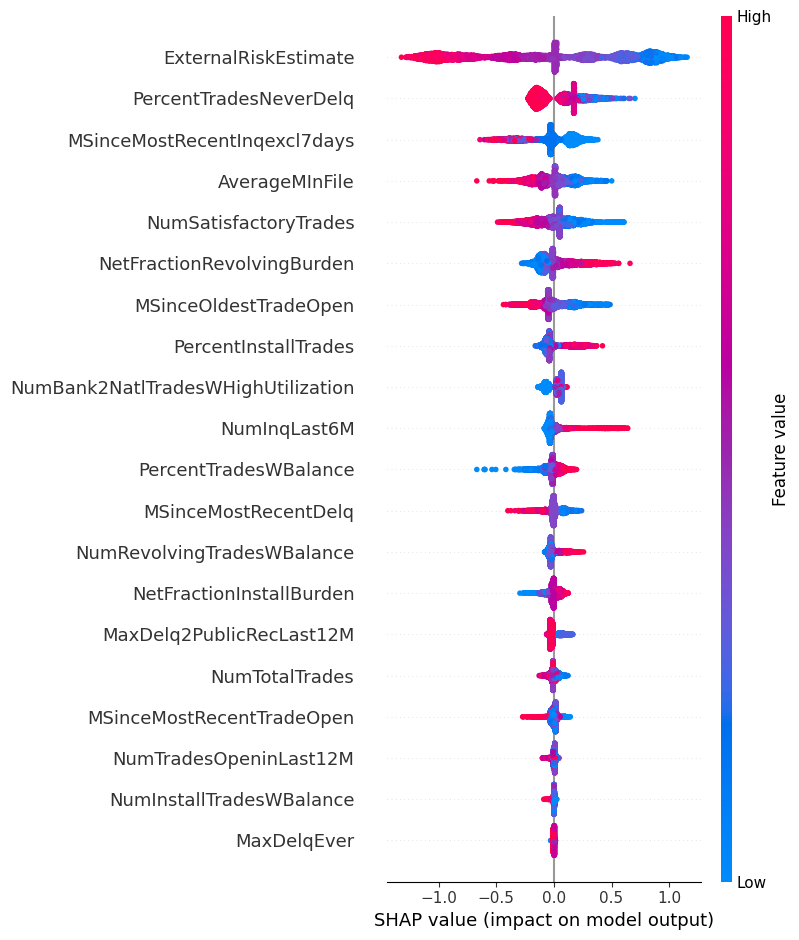

In [40]:
shap.summary_plot(shap_values, X_train)
# denied is 1
# approved is 0

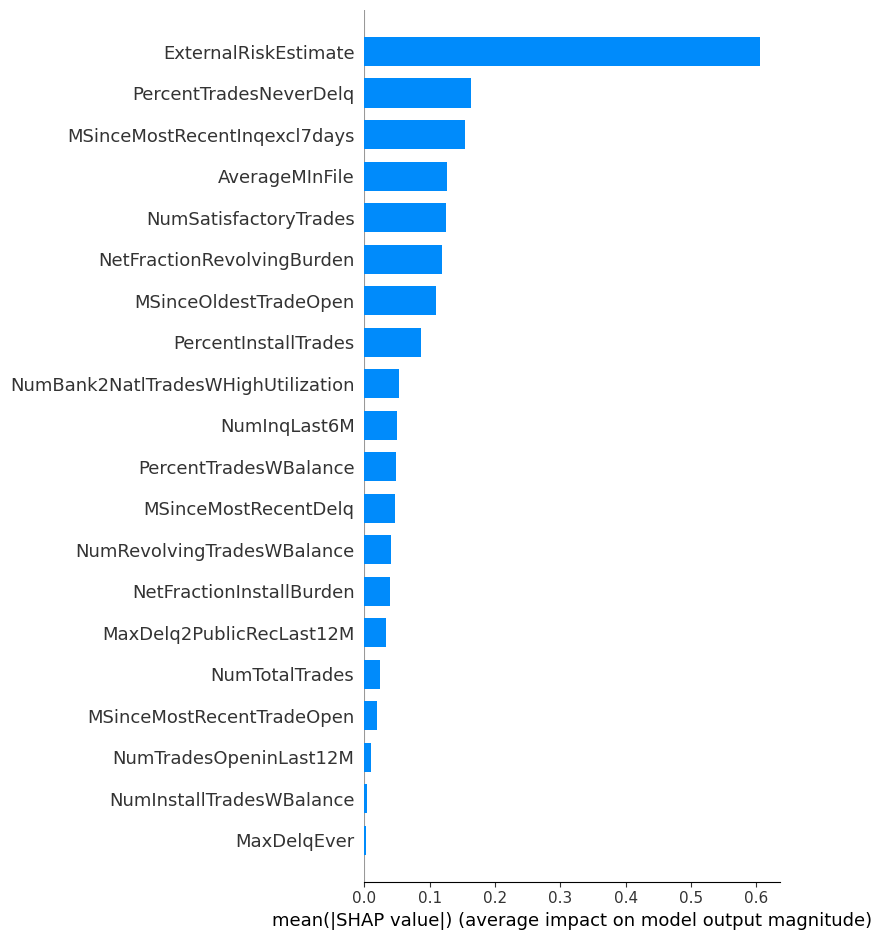

In [41]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [42]:
'''
shap_sum = np.abs(shap_values).mean(axis=0)
importance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T
importance_df.columns = ['column_name', 'shap_importance']
importance_df = importance_df.sort_values('shap_importance', ascending=False)
importance_df
'''

"\nshap_sum = np.abs(shap_values).mean(axis=0)\nimportance_df = pd.DataFrame([X_test.columns.tolist(), shap_sum.tolist()]).T\nimportance_df.columns = ['column_name', 'shap_importance']\nimportance_df = importance_df.sort_values('shap_importance', ascending=False)\nimportance_df\n"

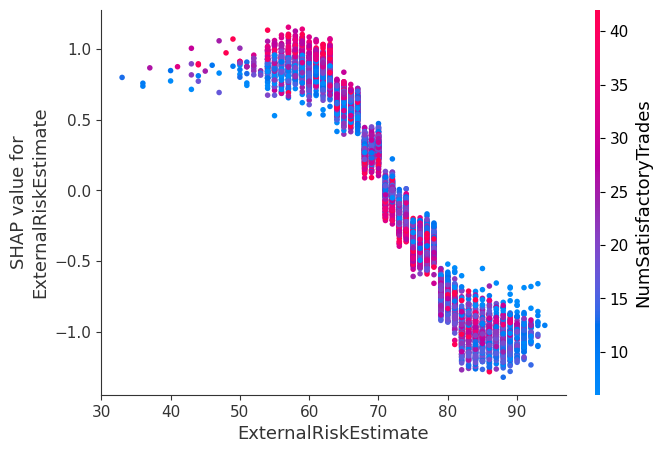

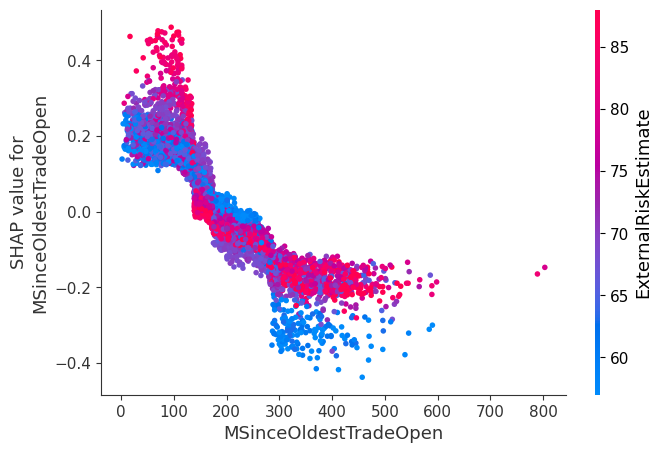

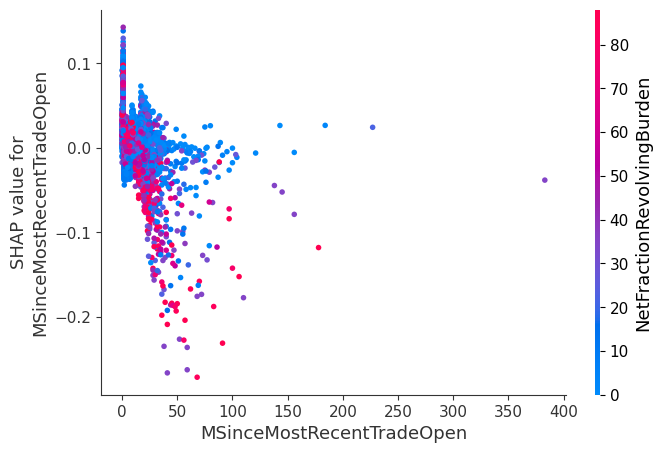

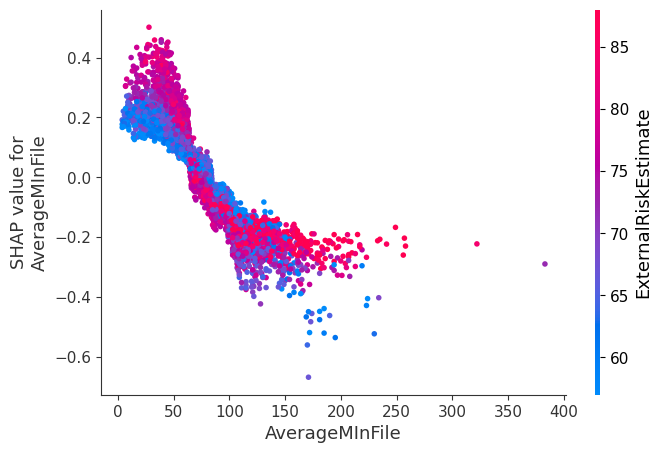

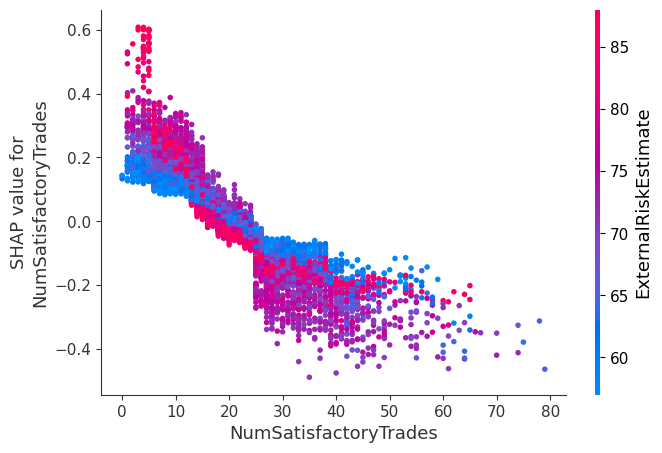

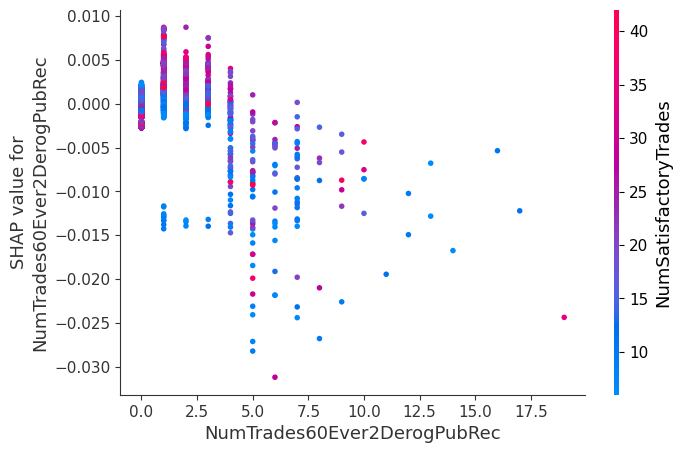

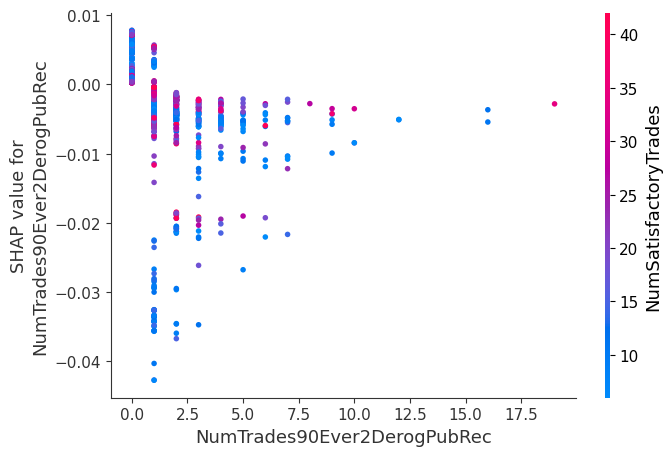

In [43]:
for i in range(7):
  shap.dependence_plot(i, shap_values, X_train)


### **3.1.2 Local Explaination by LIME** (use Dummy data)

In [44]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=predictor.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')



In [45]:
# Explain individual prediction using LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_dummy.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')
# For example, predict the 1st observation on dumm dataset
X_observation = X_dummy.iloc[0]        
explanation = explainer.explain_instance(X_observation.values, xgb_model.predict_proba)
explanation.show_in_notebook()

Intercept 0.21324407729091194
Prediction_local [0.90410632]
Right: 0.9045668


** tabular format ** 

In [46]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T

0
ExternalRiskEstimate <= 67.50           0.23
MSinceMostRecentInqexcl7days <= 0.00    0.10
MSinceOldestTradeOpen <= 132.50         0.07
NetFractionRevolvingBurden > 29.50      0.07
PercentTradesNeverDelq <= 96.50         0.06
AverageMInFile <= 62.50                 0.05
NetFractionInstallBurden > 77.50        0.04
NumInqLast6M > 3.50                     0.04
MSinceMostRecentDelq <= 16.50           0.03
60.00 < PercentTradesWBalance <= 68.50  0.01



---



### **3.1.3 Local Explanation by ProtoDash**


---



---


In [47]:
from aix360.algorithms.protodash import ProtodashExplainer

# # from google.colab import drive
# # drive.mount('/content/drive')

In [48]:
def display_similar_clients(ml_model, user_input): 
  
  '''
   take in user's input (as a list) for prediction; 
   
   '''
  
  # sourcing from X_train and y_train, put all 'good' samples together, all 'bad' samples together
  existing_client_profiles = pd.concat([y_train, X_train], axis=1)

  good_client_con = existing_client_profiles.copy()['RiskPerformance'] == 0.0
  good_client_profiles = X_train.loc[good_client_con, :]

  bad_client_con = existing_client_profiles.copy()['RiskPerformance'] == 1.0
  bad_client_profiles = X_train.loc[bad_client_con, :]

  # make prediction on user input

  index = ['ExternalRiskEstimate', 'MSinceOldestTradeOpen',
       'MSinceMostRecentTradeOpen', 'AverageMInFile', 'NumSatisfactoryTrades',
       'NumTrades60Ever2DerogPubRec', 'NumTrades90Ever2DerogPubRec',
       'PercentTradesNeverDelq', 'MSinceMostRecentDelq',
       'MaxDelq2PublicRecLast12M', 'MaxDelqEver', 'NumTotalTrades',
       'NumTradesOpeninLast12M', 'PercentInstallTrades',
       'MSinceMostRecentInqexcl7days', 'NumInqLast6M', 'NumInqLast6Mexcl7days',
       'NetFractionRevolvingBurden', 'NetFractionInstallBurden',
       'NumRevolvingTradesWBalance', 'NumInstallTradesWBalance',
       'NumBank2NatlTradesWHighUtilization', 'PercentTradesWBalance']
  pred_dummy = ml_model.predict(np.array(user_input).reshape(1,-1))[0]
  dummy_applicant = pd.concat([pd.Series(user_input, index=index), pd.Series({'RiskPerformance':pred_dummy})], axis=0)
  dummy_applicant = pd.DataFrame(dummy_applicant)
  dummy_applicant = dummy_applicant.T.replace({'RiskPerformance':{0.0:'pred: approve', 1.0:'pred: decline'}}).T
  dummy_applicant = dummy_applicant.rename(columns={0:'User Input'})


  # implement protodash
  ## if prediction is 1.0, stack the dummy applicant with exsiting 'bad' applicants
  ## if prediction is 0.0, stack the dummy applicant with existing 'good' applicants

  if pred_dummy == 1.0:

    explainer = ProtodashExplainer()
    W, S, SetValues = explainer.explain(np.array(user_input).reshape(1,-1), bad_client_profiles.values, m=3)

    similar_clients = bad_client_profiles.iloc[S, :]
    similar_clients = similar_clients.reset_index(drop=True)
    y_bad = y_train[bad_client_con]
    similar_clients['RiskPerformance'] = y_bad.iloc[S].values
    similar_clients = similar_clients.replace({'RiskPerformance':{0.0:'paid', 1.0:'default'}})
    similar_clients = similar_clients.rename(index={0:'Existing Client 1', 1:'Existing Client 2', 2:'Existing Client 3'})
    similar_clients = similar_clients.T
    similar_clients = pd.concat([dummy_applicant, similar_clients], axis=1)

  else:

    explainer = ProtodashExplainer()
    W, S, SetValues = explainer.explain(np.array(user_input).reshape(1,-1), good_client_profiles.values, m=3)

    similar_clients = good_client_profiles.iloc[S, :]
    similar_clients = similar_clients.reset_index(drop=True)
    y_good = y_train[good_client_con]
    similar_clients['RiskPerformance'] = y_good.iloc[S].values
    similar_clients = similar_clients.replace({'RiskPerformance':{0.0:'paid', 1.0:'default'}})
    similar_clients = similar_clients.rename(index={0:'Existing Client 1', 1:'Existing Client 2', 2:'Existing Client 3'})
    similar_clients = similar_clients.T
    similar_clients = pd.concat([dummy_applicant, similar_clients], axis=1)


  slice_idx = pd.IndexSlice
  slice_ = slice_idx[slice_idx[:'PercentTradesWBalance'], slice_idx['Existing Client 1':'Existing Client 3']]
  return similar_clients.style.apply(lambda x: (abs((x+1e-10)/(similar_clients['User Input'][:-1]+1e-10) - 1) <= 0.2).map({True:'background-color: yellow', False: ''}), subset=slice_).set_precision(0)


In [59]:
dummy_idx = 0
user_input = [i for i in X_dummy.iloc[dummy_idx,:].values]
user_input
# g = display_similar_clients(xgb_model, user_input)
# g.to_html()


[61.0,
 79.0,
 4.0,
 36.0,
 19.0,
 0.0,
 0.0,
 95.0,
 5.0,
 4.0,
 6.0,
 19.0,
 3.0,
 26.0,
 0.0,
 6.0,
 6.0,
 31.0,
 86.0,
 5.0,
 3.0,
 1.0,
 62.0]

## **3.2 Decision Tree**

### **3.2.1 Global Explaination by SHAP**

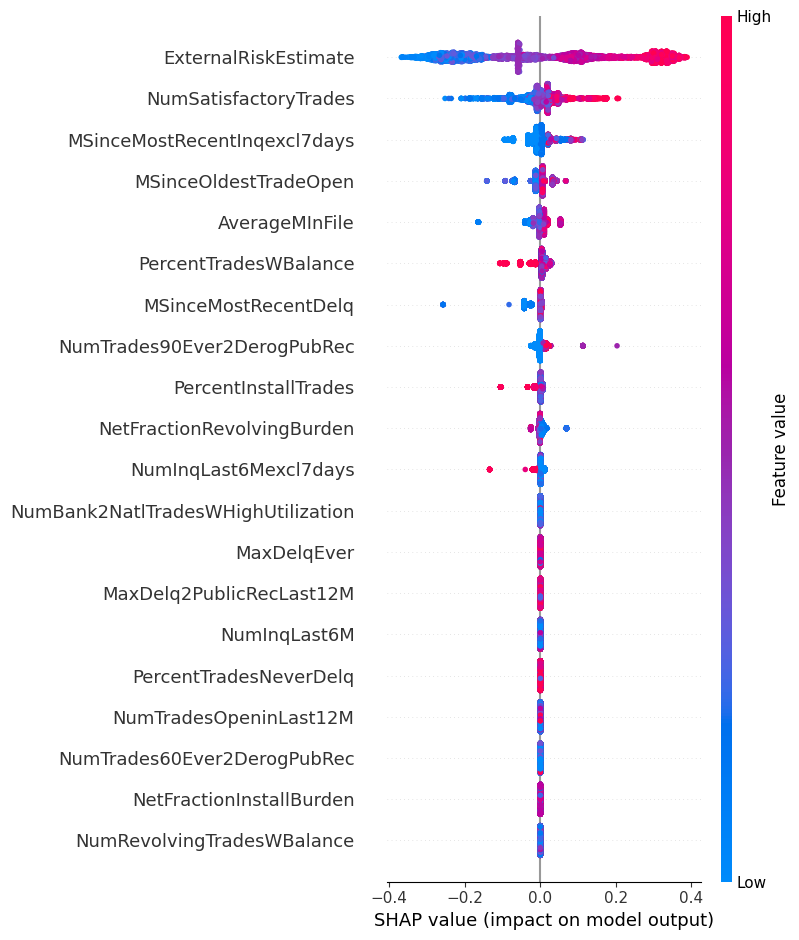

In [50]:
# explian global model using TreeExplainer
explainer = shap.TreeExplainer(dt_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values[0], X_train)

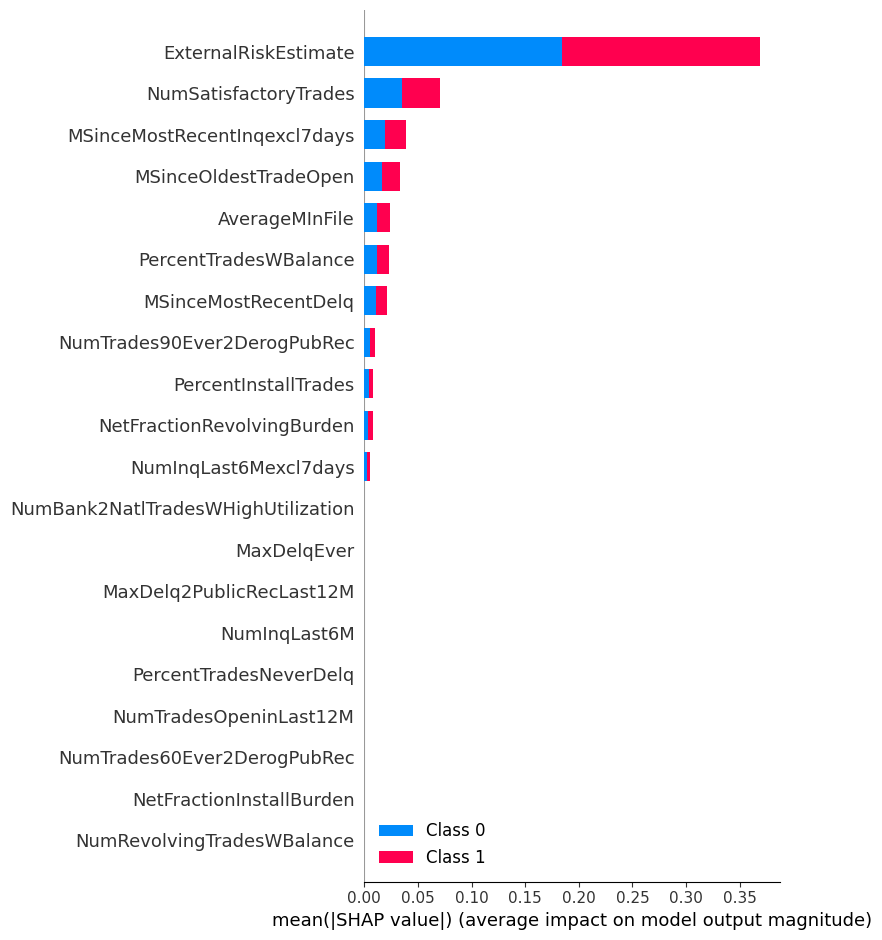

In [51]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [52]:
# for i in range(7):
#   shap.dependence_plot(i, shap_values, X_train)

### 3.2.2 Local Explaination by LIME

In [53]:
# Explain individual prediction using LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_dummy.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')

In [ ]:
 heloc = pd.read_csv("../data/heloc_dataset.csv")
df= heloc.copy()
df.replace({"Bad":1, "Good":0}, inplace=True)

X = df.drop('RiskPerformance', axis=1)
y = df['RiskPerformance']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=8)

xgb_model = xgb.XGBClassifier(objective="reg:logistic", 
                            seed=70, 
                            col_sample_bytree=0.4,
                            learning_rate= 0.01, 
                            max_depth= 5,
                            n_estimators=500,
                            alpha=10)

xgb_model = xgb_model.fit(X_train.values, y_train)

dt_model = DecisionTreeClassifier(max_leaf_nodes = 12, random_state=0, criterion='entropy')
dt_model = dt_model.fit(X_train, y_train)

svc_model = SVC(kernel='rbf', probability=True)
svc_model= svc_model.fit(X_train, y_train)

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                feature_names=X_train.columns, 
                                                verbose=True, 
                                                class_names=['Approved', 'Denied'],
                                                mode='classification')
pred = [[67.4, 184.21, 8.54, 73.84, 19.43, 0.04, -0.14, 86.66, 6.76, 4.93, 5.51, 20.86, 1.25, 32.17, -0.33, 0.87, 0.81, 31.63, 39.16, 3.19, 0.98, 0.02, 1.1]]



[22:57:14] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "col_sample_bytree" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [ ]:
pred_series = pd.Series(np.asarray(pred[0]), index=X_train.columns)

exp = explainer.explain_instance(pred_series, xgb_model.predict_proba)



Intercept 0.48001814552347677
Prediction_local [0.6297737]
Right: 0.61863995


In [ ]:
# storing a new observation
# i = random.randint(0, len(X_test))
# X_observation = X_test.iloc[i, :]


# For example, LIME explain the prediction on the 1st observation of dummy dataset
X_dummy_observation = X_dummy.iloc[0]        # This is for front-end to pick the observation 
explanation = explainer.explain_instance(X_dummy_observation.values, dt_model.predict_proba)

Intercept 0.3730864060074464
Prediction_local [0.85789265]
Right: 0.850253807106599


** tabular format **

In [ ]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T

0
ExternalRiskEstimate <= 63.00                      0.33
-7.00 < MSinceMostRecentInqexcl7days <= 0.00       0.07
48.00 < PercentTradesWBalance <= 67.00             0.03
AverageMInFile <= 52.00                            0.02
MaxDelq2PublicRecLast12M <= 4.00                   0.01
MSinceOldestTradeOpen <= 118.00                    0.01
2.00 < NumInstallTradesWBalance <= 3.00            0.01
0.00 < NumBank2NatlTradesWHighUtilization <= 1.00 -0.01
20.00 < PercentInstallTrades <= 32.00              0.01
5.00 < MaxDelqEver <= 6.00                         0.01



---







In [ ]:
# Another example, LIME explain the prediction on the 4th observation of dummy dataset
X_dummy_observation = X_dummy.iloc[3]         
explanation = explainer.explain_instance(X_dummy_observation.values, dt_model.predict_proba)
explanation.show_in_notebook()

Intercept 0.5744969624634916
Prediction_local [0.27079348]
Right: 0.32098765432098764


** tabular format **

In [ ]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T

0
ExternalRiskEstimate > 80.00                -0.36
NumSatisfactoryTrades <= 12.00               0.05
67.00 < PercentTradesWBalance <= 82.00       0.02
0.00 < MSinceMostRecentInqexcl7days <= 1.00 -0.02
MSinceMostRecentTradeOpen <= 3.00           -0.01
1.00 < NumInqLast6Mexcl7days <= 2.00         0.01
32.00 < PercentInstallTrades <= 44.00        0.01
6.00 < MaxDelq2PublicRecLast12M <= 7.00      0.01
96.00 < PercentTradesNeverDelq <= 100.00    -0.01
48.00 < NetFractionInstallBurden <= 79.00   -0.01



---



---



### 3.2.3 Local Explaination by ProtoDash

In [ ]:
dummy_idx = 0
user_input = [i for i in X_dummy.iloc[dummy_idx,:].values]
display_similar_clients(dt_model, user_input)

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00 -2.0000e+04  4e+00  1e+00  1e+00
 1:  3.2641e+04 -4.6053e+08  2e+05  1e+00  1e+00
 2:  2.5043e+05 -4.5736e+09  2e+06  1e+00  1e+00
 3:  2.5526e+05 -4.6387e+09  2e+06  1e+00  1e+00
 4:  2.4551e+04 -5.6663e+09  3e+06  1e+00  1e+00
 5:  3.2821e+05 -2.2959e+10  1e+07  1e+00  1e+00
 6:  5.2584e+06 -3.5965e+13  3e+10  1e+00  1e+00
 7:  1.3907e+07 -2.7463e+16  3e+13  1e+00  1e+00
 8:  1.4540e+13 -2.1655e+22  2e+22  6e-14  1e-03
 9:  1.4540e+13 -2.1655e+20  2e+20  6e-16  1e-03
10:  1.4540e+13 -2.1655e+18  2e+18  2e-16  6e-05
11:  1.4540e+13 -2.1676e+16  2e+16  8e-17  2e-07
12:  1.4539e+13 -2.3713e+14  3e+14  4e-16  1e-09
13:  1.4428e+13 -2.2796e+13  4e+13  4e-17  2e-10
14:  4.0911e+10 -6.1343e+13  6e+13  2e-16  2e-10
15:  3.3857e+10 -1.0313e+12  1e+12  2e-16  1e-11
16:  6.3643e+09 -2.7335e+10  3e+10  2e-17  7e-13
17:  9.3763e+08 -1.1638e+09  2e+09  8e-17  1e-14
18:  1.3332e+08 -1.4904e+08  3e+08  2e-16  4e-14
19:  1.8759e+07 -2.18

## **3.3 Support Vector Machine**





### **3.3.1 Global Explaination by SHAP**

In [ ]:
# Explain global model using KernelExplainer
explainer_all = shap.KernelExplainer(model=svc.predict_proba, data=X_train, link="logit")

Using 7007 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [ ]:
explainer = shap.KernelExplainer(model=svc.predict_proba,data=shap.sample(X_train,50))

In [ ]:
# Be patient! This'll take a while to run. We can modify the number of test sample,the bigger sample the longer it runs. 
shap_values = explainer.shap_values(X_train[:50], approximate=True)

 10%|█         | 5/50 [02:18<20:44, 27.66s/it]

In [ ]:
shap.summary_plot(shap_values, X_train)

### 3.3.2 Local Explaination by LIME

In [ ]:
# Explain individual prediction using LimeTabularExplainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_dummy.values, 
                                                   feature_names=X_train.columns, 
                                                   verbose=True, 
                                                   class_names=['Approved', 'Denied'],
                                                   mode='classification')

In [ ]:
# For example, LIME explain the prediction on the 4th observation of dummy dataset
X_dummy_observation = X_dummy.iloc[3]      
explanation = explainer.explain_instance(X_dummy_observation.values, svc_model.predict_proba)
explanation.show_in_notebook()

** tabular format **

In [ ]:
result_list = explanation.as_list()
columns = [tup[0] for tup in result_list]
values = [round(tup[1], 2)for tup in result_list]

exp_df = pd.DataFrame([values], columns=columns)
exp_df.T



---



---



### 3.3.3 Local Explaination by ProtoDash


In [ ]:
dummy_idx = 0
user_input = [i for i in X_dummy.iloc[dummy_idx,:].values]
display_similar_clients(svc_model, user_input)